<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [179]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [181]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [183]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [184]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


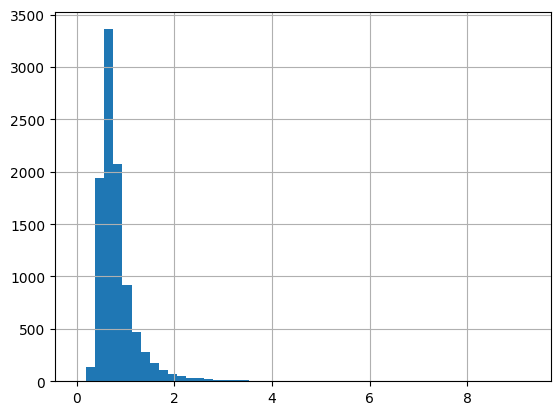

In [185]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

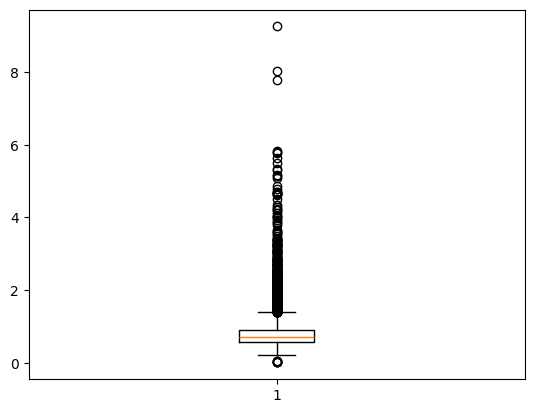

In [186]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [187]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


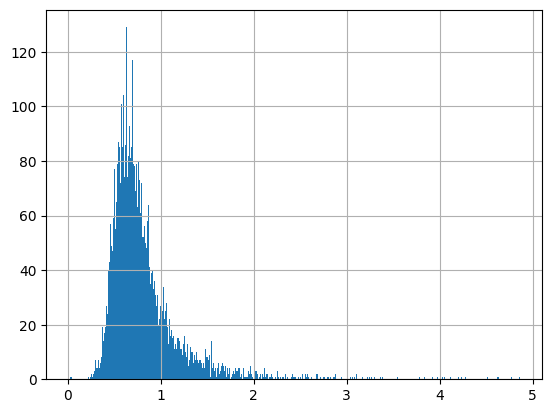

In [188]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

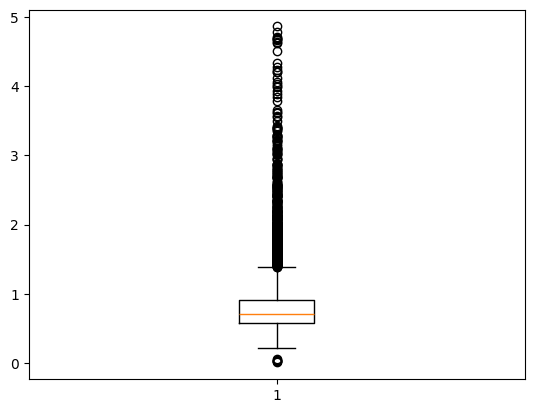

In [189]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [191]:
# Define drift function for Model 6, dependent on both task and HSF_emo conditions
def drift_function(task_1, task_2, task_3, HSF_emo_1, HSF_emo_2, 
                  drift_task1, drift_task2, drift_task3, drift_emo1, drift_emo2, 
                  leak, t, x):
    """
    Drift rate function for Model 6, incorporating both task and HSF_emo effects.
    
    This function dynamically adjusts evidence accumulation speed based on experimental 
    conditions (task and HSF_emo) and introduces position dependency through a leaky integrator.
    This design is suitable for studying complex influences of conditions on decision processes.
    
    Parameters:
    - task_1, task_2, task_3: Dummy variables representing task categories.
    - HSF_emo_1, HSF_emo_2: Dummy variables representing HSF_emo levels.
    - drift_task1, drift_task2, drift_task3: Drift parameters for each task category.
    - drift_emo1, drift_emo2: Drift parameters for each HSF_emo level.
    - leak: Leak parameter for the integrator.
    - t: Time (not used directly but included for consistency with pyDDM).
    - x: Accumulated evidence.
    
    Returns:
    - Adjusted drift rate incorporating task, HSF_emo, and leaky integration.
    """
    # Calculate base drift rate as a linear combination of task and HSF_emo conditions
    base_drift = (drift_task1 * task_1 + drift_task2 * task_2 + drift_task3 * task_3 +
                  drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)
    
    # Apply leaky integrator to adjust drift based on accumulated evidence
    drift = base_drift - leak * x
    
    # Check for numerical stability
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):
        print(f"Drift function error: {drift}")
        
    return drift * np.ones_like(x)  # Ensure output shape matches input x for compatibility with pyDDM

In [192]:
# Define bound function with exponential decay
def bound_function(threshold, invtau, t):
    """
    Bound function with exponential decay for Model 6.
    
    This implements a collapsing boundary model, where the decision threshold decreases 
    over time. This approach models urgency effects in the experiment, where participants 
    become more likely to make a decision under time pressure.
    
    Parameters:
    - threshold: Initial decision threshold.
    - invtau: Inverse time constant (decay rate) for the exponential decay.
    - t: Time.
    
    Returns:
    - Decaying decision boundary over time.
    """
    bound = threshold * np.exp(-t * invtau)  # Calculate exponentially decaying boundary
    
    # Check for numerical stability
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):
        print(f"Bound function error: {bound}")
    
    return bound

In [193]:
# Define starting position function dependent on task conditions
def starting_position_function(task_1, task_2, task_3, sp1, sp2, sp3):
    """
    Starting position function for Model 6, dependent on task conditions.
    
    This function allows the model to capture task-specific initial biases or prior 
    expectations. If tasks represent different difficulty levels or priorities, 
    this function can adjust the starting point of evidence accumulation accordingly.
    
    Parameters:
    - task_1, task_2, task_3: Dummy variables representing task categories.
    - sp1, sp2, sp3: Starting position parameters for each task category.
    
    Returns:
    - Task-dependent starting position for evidence accumulation.
    """
    # Calculate starting position as a linear combination of task conditions
    starting_position = sp1 * task_1 + sp2 * task_2 + sp3 * task_3
    
    # Check for numerical stability
    if np.any(np.isnan(starting_position)) or np.any(np.isinf(starting_position)):
        print(f"Starting_position function error: {starting_position}")
        
    return starting_position

<a id="section5"></a>
# 5. Build and Configure Model

In [195]:
# Build and configure Model 6: drift depends on task and HSF_emo, bounds decay over time, starting position depends on task
model_6 = pyddm.gddm(
    drift=drift_function,             # Use the custom task and HSF_emo-dependent drift function
    noise=1.0,                        # Fixed noise level for the diffusion process
    bound=bound_function,             # Use the custom collapsing boundary function
    nondecision="nt",                 # Non-decision time parameter
    starting_position=starting_position_function,  # Use the custom task-dependent starting position function
    parameters={
        # Drift parameters for task and HSF_emo conditions
        "drift_task1": (-1, 1), "drift_task2": (-1, 1), "drift_task3": (-1, 1),
        "drift_emo1": (0, 2.5), "drift_emo2": (-3, 0),
        # Threshold parameter
        "threshold": (0.8, 1),
        # Starting position parameters for each task condition
        "sp1": (-0.2, 0.5), "sp2": (-0.5, 0.5), "sp3": (-0.2, 0.5),
        # Other model parameters
        "nt": (0.1, 1),              # Range for non-decision time
        "leak": (0, 0.03),       # Range for leak parameter in the integrator
        "invtau": (0.1, 0.5)         # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify task and HSF_emo conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [197]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [199]:
# Attempt to fit Model 6 to the filtered data sample using BIC loss
try:
    model_6.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during model fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current model parameters: {model_6.parameters}")  # Display parameters if fitting fails

Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.5269109075688434, minval=-1, maxval=1), drift_task2=Fitted(-0.7662829721456789, minval=-1, maxval=1), drift_task3=Fitted(-0.8566495712799956, minval=-1, maxval=1), drift_emo1=Fitted(0.07088006292350912, minval=0, maxval=2.5), drift_emo2=Fitted(-1.7936444590509013, minval=-3, maxval=0), leak=Fitted(0.015016945125948391, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9119324451077696, minval=0.8, maxval=1), invtau=Fitted(0.2400131515109176, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.3484914683352639, minval=-0.2, maxval=0.5), sp2=Fitted(-0.04639888740673409, minval=-0.5, maxval=0.5), sp3=Fitted(0.4508734729720967, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.19335097347454733, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=31705.82955082509
Info: Model(name='', d

differential_evolution step 1: f(x)= 16035.650964430737


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.5504132787601064, minval=-1, maxval=1), drift_task2=Fitted(-0.4218883410532195, minval=-1, maxval=1), drift_task3=Fitted(0.4683983488680923, minval=-1, maxval=1), drift_emo1=Fitted(0.6042410068708206, minval=0, maxval=2.5), drift_emo2=Fitted(-1.366652989038443, minval=-3, maxval=0), leak=Fitted(0.016455849169821422, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8383938305534749, minval=0.8, maxval=1), invtau=Fitted(0.34806191727140334, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.16701737967706784, minval=-0.2, maxval=0.5), sp2=Fitted(0.20639426832079544, minval=-0.5, maxval=0.5), sp3=Fitted(0.04727130298058152, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.11419847269481859, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=26367.027271060564
Info: Model(name='', d

differential_evolution step 2: f(x)= 15325.889287583326


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.0839701361911106, minval=-1, maxval=1), drift_task2=Fitted(0.5842313870880769, minval=-1, maxval=1), drift_task3=Fitted(-0.5719981879255145, minval=-1, maxval=1), drift_emo1=Fitted(0.8827267748566214, minval=0, maxval=2.5), drift_emo2=Fitted(-1.2036366154046538, minval=-3, maxval=0), leak=Fitted(0.009088651620902376, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9641920973122451, minval=0.8, maxval=1), invtau=Fitted(0.23202692360296195, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.04373486150988301, minval=-0.2, maxval=0.5), sp2=Fitted(-0.40938967065295445, minval=-0.5, maxval=0.5), sp3=Fitted(0.16421220010376503, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.15415604958236495, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21915.848262851807
Info: Model(name=''

differential_evolution step 3: f(x)= 15241.325002269139


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.7324684217326096, minval=-1, maxval=1), drift_task2=Fitted(-0.09425236569177364, minval=-1, maxval=1), drift_task3=Fitted(-0.5719981879255145, minval=-1, maxval=1), drift_emo1=Fitted(1.985139888208819, minval=0, maxval=2.5), drift_emo2=Fitted(-1.883671846445897, minval=-3, maxval=0), leak=Fitted(0.014737942513427972, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8930230592415381, minval=0.8, maxval=1), invtau=Fitted(0.3548021481035467, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.3495477160735826, minval=-0.2, maxval=0.5), sp2=Fitted(-0.3470004533417498, minval=-0.5, maxval=0.5), sp3=Fitted(0.16421220010376503, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.13447681864094518, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=35305.08516179343
Info: Model(name='', drif

differential_evolution step 4: f(x)= 15229.867018571806


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.42920090206993244, minval=-1, maxval=1), drift_task2=Fitted(-0.9900154661224797, minval=-1, maxval=1), drift_task3=Fitted(0.5998754835292126, minval=-1, maxval=1), drift_emo1=Fitted(0.8827267748566214, minval=0, maxval=2.5), drift_emo2=Fitted(-2.2719372232995347, minval=-3, maxval=0), leak=Fitted(0.015045136271743727, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8681892809080206, minval=0.8, maxval=1), invtau=Fitted(0.23202692360296195, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.3504137608589193, minval=-0.2, maxval=0.5), sp2=Fitted(-0.40938967065295445, minval=-0.5, maxval=0.5), sp3=Fitted(0.3412622546589238, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2619950338978939, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=32267.856036518893
Info: Model(name='', d

differential_evolution step 5: f(x)= 14657.929210063274


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.705570049373972, minval=-1, maxval=1), drift_task2=Fitted(0.24324611930697992, minval=-1, maxval=1), drift_task3=Fitted(0.07328552491850293, minval=-1, maxval=1), drift_emo1=Fitted(1.5126148512825843, minval=0, maxval=2.5), drift_emo2=Fitted(-1.2036366154046538, minval=-3, maxval=0), leak=Fitted(0.010427471980878919, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9641920973122451, minval=0.8, maxval=1), invtau=Fitted(0.45751035139070195, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.04373486150988301, minval=-0.2, maxval=0.5), sp2=Fitted(-0.40938967065295445, minval=-0.5, maxval=0.5), sp3=Fitted(-0.04613058882892285, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24435885756374792, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20692.97467605195
Info: Model(name=''

differential_evolution step 6: f(x)= 14657.929210063274


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.34612520381050027, minval=-1, maxval=1), drift_task2=Fitted(0.028169511435894412, minval=-1, maxval=1), drift_task3=Fitted(0.07328552491850293, minval=-1, maxval=1), drift_emo1=Fitted(1.043156650199514, minval=0, maxval=2.5), drift_emo2=Fitted(-1.2036366154046538, minval=-3, maxval=0), leak=Fitted(0.009556734122598864, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8865969815626666, minval=0.8, maxval=1), invtau=Fitted(0.12198561960057563, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.04373486150988301, minval=-0.2, maxval=0.5), sp2=Fitted(-0.40938967065295445, minval=-0.5, maxval=0.5), sp3=Fitted(0.03961242197777805, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24435885756374792, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=19961.276050566532
Info: Model(name='

differential_evolution step 7: f(x)= 14657.929210063274


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.34612520381050027, minval=-1, maxval=1), drift_task2=Fitted(0.7345647513904003, minval=-1, maxval=1), drift_task3=Fitted(-0.32576004678098913, minval=-1, maxval=1), drift_emo1=Fitted(1.043156650199514, minval=0, maxval=2.5), drift_emo2=Fitted(-0.007225823733003622, minval=-3, maxval=0), leak=Fitted(0.016104327642417305, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9436212682843913, minval=0.8, maxval=1), invtau=Fitted(0.3490071900933386, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.04373486150988301, minval=-0.2, maxval=0.5), sp2=Fitted(-0.2095989260513072, minval=-0.5, maxval=0.5), sp3=Fitted(0.13830299394457185, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24435885756374792, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16321.295999496695
Info: Model(name=''

differential_evolution step 8: f(x)= 14657.929210063274


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.8349032100930471, minval=-1, maxval=1), drift_task2=Fitted(0.7345647513904003, minval=-1, maxval=1), drift_task3=Fitted(-0.3752919591119108, minval=-1, maxval=1), drift_emo1=Fitted(2.0518988516755114, minval=0, maxval=2.5), drift_emo2=Fitted(-0.24957888903347136, minval=-3, maxval=0), leak=Fitted(0.010479367873695633, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8599919992033375, minval=0.8, maxval=1), invtau=Fitted(0.29170519501675074, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.03908947191470109, minval=-0.2, maxval=0.5), sp2=Fitted(0.019769273202551174, minval=-0.5, maxval=0.5), sp3=Fitted(0.13830299394457185, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.315944332511192, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=19945.025404539883
Info: Model(name='', d

differential_evolution step 9: f(x)= 14657.929210063274


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.3116366115698853, minval=-1, maxval=1), drift_task2=Fitted(-0.26382342154452365, minval=-1, maxval=1), drift_task3=Fitted(-0.32576004678098913, minval=-1, maxval=1), drift_emo1=Fitted(1.043156650199514, minval=0, maxval=2.5), drift_emo2=Fitted(-0.007225823733003622, minval=-3, maxval=0), leak=Fitted(0.016104327642417305, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8869051283976463, minval=0.8, maxval=1), invtau=Fitted(0.3490071900933386, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.15461533170340566, minval=-0.2, maxval=0.5), sp2=Fitted(-0.08248253054714272, minval=-0.5, maxval=0.5), sp3=Fitted(-0.06176485508689197, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2945231462690709, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15051.84120561504
Info: Model(name='

differential_evolution step 10: f(x)= 14581.982394216146


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07220732231711313, minval=-1, maxval=1), drift_task2=Fitted(0.11769970334467894, minval=-1, maxval=1), drift_task3=Fitted(-0.034016432285454146, minval=-1, maxval=1), drift_emo1=Fitted(1.043156650199514, minval=0, maxval=2.5), drift_emo2=Fitted(-0.15097687853780184, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8869051283976463, minval=0.8, maxval=1), invtau=Fitted(0.38969730920358797, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.09934388899028262, minval=-0.2, maxval=0.5), sp2=Fitted(0.0987475527918884, minval=-0.5, maxval=0.5), sp3=Fitted(-0.06176485508689197, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.28466968920198077, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14832.962311178659
Info: Model(name=

differential_evolution step 11: f(x)= 14581.982394216146


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7655427405037617, minval=-1, maxval=1), drift_task2=Fitted(0.43906609379684935, minval=-1, maxval=1), drift_task3=Fitted(-0.034016432285454146, minval=-1, maxval=1), drift_emo1=Fitted(1.0804780525226632, minval=0, maxval=2.5), drift_emo2=Fitted(-0.7925707732254568, minval=-3, maxval=0), leak=Fitted(0.014514645831234551, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9754366532249854, minval=0.8, maxval=1), invtau=Fitted(0.36638724535643313, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.42040005432723415, minval=-0.2, maxval=0.5), sp2=Fitted(-0.16502445245874986, minval=-0.5, maxval=0.5), sp3=Fitted(0.22853684806432187, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.27843143928353553, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16733.71595120421
Info: Model(name='

differential_evolution step 12: f(x)= 14581.982394216146


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.15592788282538028, minval=-1, maxval=1), drift_task2=Fitted(-0.06326629627963398, minval=-1, maxval=1), drift_task3=Fitted(-0.20025352652333306, minval=-1, maxval=1), drift_emo1=Fitted(0.580079150802467, minval=0, maxval=2.5), drift_emo2=Fitted(-0.15097687853780184, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9201211837283452, minval=0.8, maxval=1), invtau=Fitted(0.3375663856778052, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.21242028015370695, minval=-0.2, maxval=0.5), sp2=Fitted(0.3153634963745211, minval=-0.5, maxval=0.5), sp3=Fitted(-0.06590115562508331, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.38696902808485245, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=19686.11423847806
Info: Model(name=''

differential_evolution step 13: f(x)= 14581.982394216146


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07220732231711313, minval=-1, maxval=1), drift_task2=Fitted(0.11769970334467894, minval=-1, maxval=1), drift_task3=Fitted(-0.15409961770484737, minval=-1, maxval=1), drift_emo1=Fitted(0.8263605927452905, minval=0, maxval=2.5), drift_emo2=Fitted(-0.6071911069744005, minval=-3, maxval=0), leak=Fitted(0.003609301792220177, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8731236660252493, minval=0.8, maxval=1), invtau=Fitted(0.38969730920358797, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.26020204570203953, minval=-0.2, maxval=0.5), sp2=Fitted(0.0239601067474281, minval=-0.5, maxval=0.5), sp3=Fitted(-0.05921221290538989, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33348827672576375, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15355.69108046046
Info: Model(name=''

differential_evolution step 14: f(x)= 14581.982394216146


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.20872299175334263, minval=-1, maxval=1), drift_task2=Fitted(-0.2832584768693701, minval=-1, maxval=1), drift_task3=Fitted(-0.20886721072941816, minval=-1, maxval=1), drift_emo1=Fitted(1.043156650199514, minval=0, maxval=2.5), drift_emo2=Fitted(-0.2942415364284581, minval=-3, maxval=0), leak=Fitted(0.01519352104787609, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8212310608547797, minval=0.8, maxval=1), invtau=Fitted(0.3284862433121899, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.13169354918838075, minval=-0.2, maxval=0.5), sp2=Fitted(0.0987475527918884, minval=-0.5, maxval=0.5), sp3=Fitted(-0.10384079015064732, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.28466968920198077, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15149.330260140008
Info: Model(name='', 

differential_evolution step 15: f(x)= 14479.731212602255


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07220732231711313, minval=-1, maxval=1), drift_task2=Fitted(0.33433522066898225, minval=-1, maxval=1), drift_task3=Fitted(0.30632085941213427, minval=-1, maxval=1), drift_emo1=Fitted(1.1394285419004762, minval=0, maxval=2.5), drift_emo2=Fitted(-0.2751409745573432, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8869051283976463, minval=0.8, maxval=1), invtau=Fitted(0.26267209675574654, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.10035794290082714, minval=-0.2, maxval=0.5), sp2=Fitted(-0.16183199108686208, minval=-0.5, maxval=0.5), sp3=Fitted(-0.08257482599152588, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2952255814124423, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15001.517771833876
Info: Model(name='

differential_evolution step 16: f(x)= 14479.731212602255


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07220732231711313, minval=-1, maxval=1), drift_task2=Fitted(0.029831182113020382, minval=-1, maxval=1), drift_task3=Fitted(0.15345847088303533, minval=-1, maxval=1), drift_emo1=Fitted(0.8044781327614619, minval=0, maxval=2.5), drift_emo2=Fitted(-0.3520452639981162, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9616519720510053, minval=0.8, maxval=1), invtau=Fitted(0.39758554762771986, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.09934388899028262, minval=-0.2, maxval=0.5), sp2=Fitted(0.08647206162120702, minval=-0.5, maxval=0.5), sp3=Fitted(0.01473390956995868, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2648437846199485, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14731.516739534962
Info: Model(name=''

differential_evolution step 17: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.5139765990288546, minval=-1, maxval=1), drift_task2=Fitted(-0.007061402872231559, minval=-1, maxval=1), drift_task3=Fitted(-0.6186632171139815, minval=-1, maxval=1), drift_emo1=Fitted(1.829458640039907, minval=0, maxval=2.5), drift_emo2=Fitted(-2.910565226597841, minval=-3, maxval=0), leak=Fitted(0.0077271699453288845, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9616519720510053, minval=0.8, maxval=1), invtau=Fitted(0.4471823699158201, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.060441134464229745, minval=-0.2, maxval=0.5), sp2=Fitted(0.03384175883662499, minval=-0.5, maxval=0.5), sp3=Fitted(-0.19873697898184337, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.295867668066441, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=32282.492365849223
Info: Model(name=''

differential_evolution step 18: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.4412680168594728, minval=-1, maxval=1), drift_task2=Fitted(-0.23107931225121903, minval=-1, maxval=1), drift_task3=Fitted(-0.2213086632805129, minval=-1, maxval=1), drift_emo1=Fitted(1.4524880532387516, minval=0, maxval=2.5), drift_emo2=Fitted(-0.1198343954239367, minval=-3, maxval=0), leak=Fitted(0.01617855552039981, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9514125909127423, minval=0.8, maxval=1), invtau=Fitted(0.4227031147524277, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.20111876674385476, minval=-0.2, maxval=0.5), sp2=Fitted(0.2929586999920408, minval=-0.5, maxval=0.5), sp3=Fitted(-0.02767250864290663, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.28644487513788214, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15550.004821277143
Info: Model(name='', 

differential_evolution step 19: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.07220732231711313, minval=-1, maxval=1), drift_task2=Fitted(0.029831182113020382, minval=-1, maxval=1), drift_task3=Fitted(-0.47594676019170545, minval=-1, maxval=1), drift_emo1=Fitted(0.8044781327614619, minval=0, maxval=2.5), drift_emo2=Fitted(-2.9034582287702593, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9616519720510053, minval=0.8, maxval=1), invtau=Fitted(0.41564239106682044, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.18229804257773685, minval=-0.2, maxval=0.5), sp2=Fitted(0.12702007588580289, minval=-0.5, maxval=0.5), sp3=Fitted(-0.07604053376843703, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2648437846199485, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=29403.32356020778
Info: Model(name='

differential_evolution step 20: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.18498556051809856, minval=-1, maxval=1), drift_task2=Fitted(0.11705032903221424, minval=-1, maxval=1), drift_task3=Fitted(0.15345847088303533, minval=-1, maxval=1), drift_emo1=Fitted(0.861042052161371, minval=0, maxval=2.5), drift_emo2=Fitted(-0.5008816643436229, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9160629622068583, minval=0.8, maxval=1), invtau=Fitted(0.3763995063066204, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0033831627794659036, minval=-0.2, maxval=0.5), sp2=Fitted(0.07164157630976586, minval=-0.5, maxval=0.5), sp3=Fitted(-0.03571559151079451, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32323222481766584, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14685.470072557531
Info: Model(name='

differential_evolution step 21: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.022272061363908913, minval=-1, maxval=1), drift_task2=Fitted(-0.25657772590412775, minval=-1, maxval=1), drift_task3=Fitted(-0.4626683777890166, minval=-1, maxval=1), drift_emo1=Fitted(1.6915475631906338, minval=0, maxval=2.5), drift_emo2=Fitted(-0.26750190029236354, minval=-3, maxval=0), leak=Fitted(0.008303664416831433, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9160629622068583, minval=0.8, maxval=1), invtau=Fitted(0.43727843134874245, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0033831627794659036, minval=-0.2, maxval=0.5), sp2=Fitted(0.07164157630976586, minval=-0.5, maxval=0.5), sp3=Fitted(-0.07294886389843164, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32323222481766584, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15037.870638735056
Info: Model(

differential_evolution step 22: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.7978414542663946, minval=-1, maxval=1), drift_task2=Fitted(-0.19416107474963007, minval=-1, maxval=1), drift_task3=Fitted(-0.31563193059716743, minval=-1, maxval=1), drift_emo1=Fitted(0.861042052161371, minval=0, maxval=2.5), drift_emo2=Fitted(-0.0679743890746285, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8504642705148138, minval=0.8, maxval=1), invtau=Fitted(0.4390616688173758, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.36974721156028545, minval=-0.2, maxval=0.5), sp2=Fitted(0.07164157630976586, minval=-0.5, maxval=0.5), sp3=Fitted(-0.03571559151079451, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.28609978390478796, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15753.174227598958
Info: Model(name=''

differential_evolution step 23: f(x)= 14458.455638895713


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.18498556051809856, minval=-1, maxval=1), drift_task2=Fitted(0.11705032903221424, minval=-1, maxval=1), drift_task3=Fitted(-0.5242437402813945, minval=-1, maxval=1), drift_emo1=Fitted(0.861042052161371, minval=0, maxval=2.5), drift_emo2=Fitted(-0.5008816643436229, minval=-3, maxval=0), leak=Fitted(0.003122143432305581, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8933267288222044, minval=0.8, maxval=1), invtau=Fitted(0.2334814049703227, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.04014991235446656, minval=-0.2, maxval=0.5), sp2=Fitted(0.07164157630976586, minval=-0.5, maxval=0.5), sp3=Fitted(-0.1562208227879335, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32323222481766584, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16497.227639869623
Info: Model(name='', d

differential_evolution step 24: f(x)= 14433.43116678605


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.690125197463846, minval=-1, maxval=1), drift_task2=Fitted(0.11705032903221424, minval=-1, maxval=1), drift_task3=Fitted(-0.4889846825094968, minval=-1, maxval=1), drift_emo1=Fitted(1.6570919231879686, minval=0, maxval=2.5), drift_emo2=Fitted(-0.5008816643436229, minval=-3, maxval=0), leak=Fitted(0.017299284201976198, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8086517638067319, minval=0.8, maxval=1), invtau=Fitted(0.3180362367298065, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.12388320441083067, minval=-0.2, maxval=0.5), sp2=Fitted(0.08472187037597823, minval=-0.5, maxval=0.5), sp3=Fitted(-0.08702799077718151, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32323222481766584, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15629.009918734702
Info: Model(name='', 

differential_evolution step 25: f(x)= 14416.005469894084


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.18498556051809856, minval=-1, maxval=1), drift_task2=Fitted(0.11705032903221424, minval=-1, maxval=1), drift_task3=Fitted(-0.4992862441141752, minval=-1, maxval=1), drift_emo1=Fitted(1.6563161779335562, minval=0, maxval=2.5), drift_emo2=Fitted(-2.216513809808606, minval=-3, maxval=0), leak=Fitted(0.0057866731539071275, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8221582428212086, minval=0.8, maxval=1), invtau=Fitted(0.3068970282522301, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0033831627794659036, minval=-0.2, maxval=0.5), sp2=Fitted(0.07164157630976586, minval=-0.5, maxval=0.5), sp3=Fitted(-0.09617698199915783, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32323222481766584, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=23146.189571316165
Info: Model(name=

differential_evolution step 26: f(x)= 14372.23802958479


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.18498556051809856, minval=-1, maxval=1), drift_task2=Fitted(-0.32728537237041655, minval=-1, maxval=1), drift_task3=Fitted(-0.20330286130212305, minval=-1, maxval=1), drift_emo1=Fitted(1.408861650554213, minval=0, maxval=2.5), drift_emo2=Fitted(-0.008420973275136134, minval=-3, maxval=0), leak=Fitted(0.006257746977799801, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.88994930789181, minval=0.8, maxval=1), invtau=Fitted(0.37601188421865156, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.0033831627794659036, minval=-0.2, maxval=0.5), sp2=Fitted(-0.004465182053838668, minval=-0.5, maxval=0.5), sp3=Fitted(-0.18465046003092303, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.329186056379434, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15171.583440943912
Info: Model(nam

differential_evolution step 27: f(x)= 14367.117568730355


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(0.18498556051809856, minval=-1, maxval=1), drift_task2=Fitted(0.11705032903221424, minval=-1, maxval=1), drift_task3=Fitted(0.15345847088303533, minval=-1, maxval=1), drift_emo1=Fitted(1.342065064514169, minval=0, maxval=2.5), drift_emo2=Fitted(-0.19313797534979282, minval=-3, maxval=0), leak=Fitted(0.011704094921944143, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9160629622068583, minval=0.8, maxval=1), invtau=Fitted(0.34184583949802216, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(0.08608460002695435, minval=-0.2, maxval=0.5), sp2=Fitted(0.09312829943881706, minval=-0.5, maxval=0.5), sp3=Fitted(-0.06385814246814941, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30727022944992766, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15354.716805540971
Info: Model(name=''

differential_evolution step 28: f(x)= 14367.117568730355
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_task1=Fitted(-0.08494906299707877, minval=-1, maxval=1), drift_task2=Fitted(-0.3759180986294681, minval=-1, maxval=1), drift_task3=Fitted(-0.1175186065005972, minval=-1, maxval=1), drift_emo1=Fitted(1.2544497379334374, minval=0, maxval=2.5), drift_emo2=Fitted(-0.17818835759065665, minval=-3, maxval=0), leak=Fitted(0.011368487175227808, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8700301701108137, minval=0.8, maxval=1), invtau=Fitted(0.390051579677588, minval=0.1, maxval=0.5)), IC=ICPointRatioEasy(sp1=Fitted(-0.034960413520190387, minval=-0.2, maxval=0.5), sp2=Fitted(0.09133518609960001, minval=-0.5, maxval=0.5), sp3=Fitted(-0.04602654888494351, minval=-0.2, maxval=0.5)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30414584155732993, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14367.117570180406
Info: Model(name=

In [200]:
# Display the fitted model details
model_6.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_task1: -0.124883
    - drift_task2: -0.308716
    - drift_task3: -0.069184
    - drift_emo1: 1.202547
    - drift_emo2: -0.169172
    - leak: 0.008935
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.865000
    - invtau: 0.381793
IC component ICPointRatioEasy:
    easy_starting_point
    Fitted parameters:
    - sp1: -0.034960
    - sp2: 0.091335
    - sp3: -0.046027
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.304146
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:


<a id="section8"></a>
# 8. Visualization and Analysis

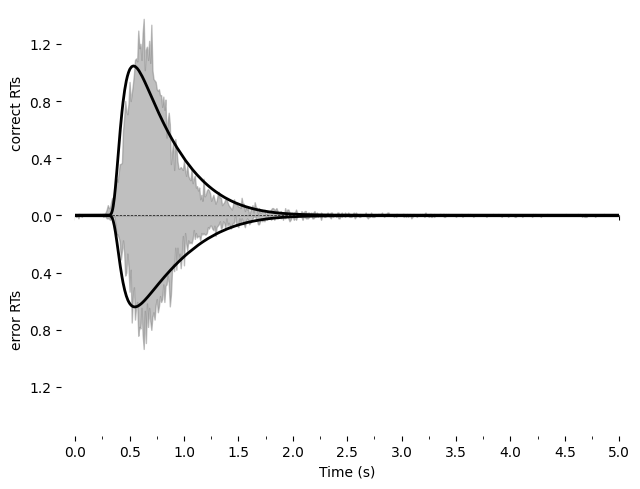

In [202]:
# Visualize model fit diagnostics to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_6, sample=data_sample_filtered)
plt.show()